<a href="https://colab.research.google.com/github/AmoghSinha/Arrowhead/blob/main/Assignment_for_Arrowhead.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook provides the code of my process in fine tuning a LLM for text summarization which was given as an assignment for Arrowhead. Please find the documentation in the github repo for the step by step process.**

##Loading the dataset in google colab

In [7]:
!pip install -q kaggle

In [8]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"amoghsinha","key":"743563e0766cc6b3aee032c20b2adea2"}'}

In [15]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [16]:
! chmod 600 ~/.kaggle/kaggle.json

In [17]:
!kaggle datasets download -d pariza/bbc-news-summary

 79% 7.00M/8.91M [00:00<00:00, 70.3MB/s]
100% 8.91M/8.91M [00:00<00:00, 82.2MB/s]


In [18]:
import zipfile
zip_ref = zipfile.ZipFile('bbc-news-summary.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

##Installing and importing libraries

In [19]:
!pip install -q transformers
!pip install -q datasets
!pip install -q peft
!pip install -q tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 9.7 MB/s eta 0:00:00


In [20]:
!pip install -q nltk

In [2]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from torch.nn.utils import clip_grad_norm_

from sklearn.model_selection import train_test_split
from tqdm import tqdm

from transformers import BartTokenizer, BartForConditionalGeneration, AdamW, get_linear_schedule_with_warmup
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline, set_seed
from transformers import DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments

import datasets
from datasets import load_metric, Dataset
from datasets import DatasetDict

import nltk
from nltk.tokenize import sent_tokenize
nltk.download("punkt")

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [23]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [1]:
!pip install rouge-score
from rouge_score import rouge_scorer

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=520ebbed9905e416ce874322d1a692938c90fd2347f19dc1338859ee5761f30d
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [75]:
import random
import re

##Data Analysis and Preprocessing

###Loading the dataset as a dataframe using pandas

In [5]:
paths = os.listdir('BBC News Summary/News Articles')
articles_path = 'BBC News Summary/News Articles/'
summaries_path = 'BBC News Summary/Summaries/'

articles = []
summaries = []
file_arr = []

for path in paths:
    files = os.listdir(articles_path + path)
    for file in files:
        article_file_path = articles_path + path + '/' + file
        summary_file_path = summaries_path + path + '/' + file
        try:
            with open (article_file_path,'r') as f:
                articles.append('.'.join([line.rstrip() for line in f.readlines()]))
            with open (summary_file_path,'r') as f:
                summaries.append('.'.join([line.rstrip() for line in f.readlines()]))
            file_arr.append(path + '/' + file)
        except:
            pass

In [49]:
df = pd.DataFrame({'path':file_arr,'article': articles,'summary':summaries})
df.head()

,path,article,summary
0,sport/073.txt,Johnson uncertain about Euro bid..Jade Johnson...,"""It's the stress,"" said Johnson.Jade Johnson i..."
1,sport/352.txt,Wood - Ireland can win Grand Slam..Former capt...,"""So many of the major England players have eit..."
2,sport/279.txt,Newcastle line up Babayaro..Newcastle manager ...,Babayaro has been in the Premiership since 199...
3,sport/447.txt,"Serena ends Sania Mirza's dream..Sania Mirza, ...","Sania Mirza, the first Indian woman to reach t..."
4,sport/242.txt,Wenger rules out new keeper..Arsenal boss Arse...,Arsenal boss Arsene Wenger says he has no plan...


In [50]:
# Function to count the number of words in a text
def count_words(text):
    return len(text.split())

df['wordcount_article'] = df['article'].apply(count_words)
df['wordcount_summary'] = df['summary'].apply(count_words)
df['category'] = df['path'].map(lambda x: str(x)[:-8])
df.head()

,path,article,summary,wordcount_article,wordcount_summary,category
0,sport/073.txt,Johnson uncertain about Euro bid..Jade Johnson...,"""It's the stress,"" said Johnson.Jade Johnson i...",177,62,sport
1,sport/352.txt,Wood - Ireland can win Grand Slam..Former capt...,"""So many of the major England players have eit...",313,153,sport
2,sport/279.txt,Newcastle line up Babayaro..Newcastle manager ...,Babayaro has been in the Premiership since 199...,127,60,sport
3,sport/447.txt,"Serena ends Sania Mirza's dream..Sania Mirza, ...","Sania Mirza, the first Indian woman to reach t...",306,128,sport
4,sport/242.txt,Wenger rules out new keeper..Arsenal boss Arse...,Arsenal boss Arsene Wenger says he has no plan...,232,83,sport


In [51]:
df.describe()

,wordcount_article,wordcount_summary
count,2224.000000,2224.000000
mean,379.286871,165.151529
std,235.081995,108.678038
min,87.000000,38.000000
25%,242.000000,103.000000
50%,327.000000,142.000000
75%,465.250000,202.000000
max,4377.000000,2073.000000


With the above table, it can be seen that some rows with extremely large numbers are skewing the data.

In [52]:
#Code to get the mean number of words category wise
df.groupby("category").mean()

,wordcount_article,wordcount_summary
category,,
business,324.641176,139.929412
entertainment,326.238342,144.049223
politics,448.654676,195.709832
sport,324.550980,143.078431
tech,497.329177,213.837905


In [53]:
# removing nans if any

df.dropna(inplace=True)
df.isnull().sum()

path                 0
article              0
summary              0
wordcount_article    0
wordcount_summary    0
category             0
dtype: int64

In [54]:
df.count()

path                 2224
article              2224
summary              2224
wordcount_article    2224
wordcount_summary    2224
category             2224
dtype: int64

In [47]:
#Plotting to see number of articles in each category

from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio

dfg=df.groupby('category').count().reset_index()
dfg=dfg.rename(columns={"article": "number of articles"})

fig = px.bar(dfg,
             x='category',
             y='number of articles',
             title='Number of articles in each category',
             barmode='stack')

fig.show()

We see from the below graph that all categories have roughly the same number of articles:

In [65]:
#Boxplot to understand the outliers
import plotly.express as px
fig = px.box(df, y="wordcount_article", labels={"wordcount_article":"Number of words of articles"}, points="outliers", title="Boxplot of the articles number of words")
fig.show()

In [66]:
fig = px.box(df, y="wordcount_summary", labels={"wordcount_summary":"Number of words of summary"}, points="outliers", title="Boxplot of the summary number of words")
fig.show()

Looking at the word count distributon, we see there are some outliers. Our goal will be to have a decently uniformed data so we will choose the records where article word count is less than 500.

In [67]:
# removing the samples of very long sequences

filtered_df = df[(df['wordcount_article'] <= 500)]
filtered_df.reset_index(drop=True, inplace=True)
filtered_df

,path,article,summary,wordcount_article,wordcount_summary,category
0,sport/073.txt,Johnson uncertain about Euro bid..Jade Johnson...,"""It's the stress,"" said Johnson.Jade Johnson i...",177,62,sport
1,sport/352.txt,Wood - Ireland can win Grand Slam..Former capt...,"""So many of the major England players have eit...",313,153,sport
2,sport/279.txt,Newcastle line up Babayaro..Newcastle manager ...,Babayaro has been in the Premiership since 199...,127,60,sport
3,sport/447.txt,"Serena ends Sania Mirza's dream..Sania Mirza, ...","Sania Mirza, the first Indian woman to reach t...",306,128,sport
4,sport/242.txt,Wenger rules out new keeper..Arsenal boss Arse...,Arsenal boss Arsene Wenger says he has no plan...,232,83,sport
...,...,...,...,...,...,...
1778,tech/398.txt,Spam e-mails tempt net shoppers..Computer user...,A third of them read unsolicited junk e-mail a...,352,130,tech
1779,tech/169.txt,2D Metal Slug offers retro fun..Like some dril...,But at a time when blockbuster titles offer on...,310,147,tech
1780,tech/241.txt,Hollywood to sue net film pirates..The US movi...,The US movie industry has launched legal actio...,229,88,tech
1781,tech/329.txt,Intel unveils laser breakthrough..Intel has sa...,While work has been done to make some of the c...,477,219,tech


In [68]:
print(df.describe())
print(filtered_df.describe())

       wordcount_article  wordcount_summary
count        2224.000000        2224.000000
mean          379.286871         165.151529
std           235.081995         108.678038
min            87.000000          38.000000
25%           242.000000         103.000000
50%           327.000000         142.000000
75%           465.250000         202.000000
max          4377.000000        2073.000000
       wordcount_article  wordcount_summary
count        1783.000000        1783.000000
mean          301.922042         131.076276
std            97.529892          44.171673
min            87.000000          38.000000
25%           225.000000          96.000000
50%           291.000000         126.000000
75%           380.000000         164.000000
max           499.000000         275.000000


As can be seen with the below graph, the number of words now, more or less are in a normal distribution.

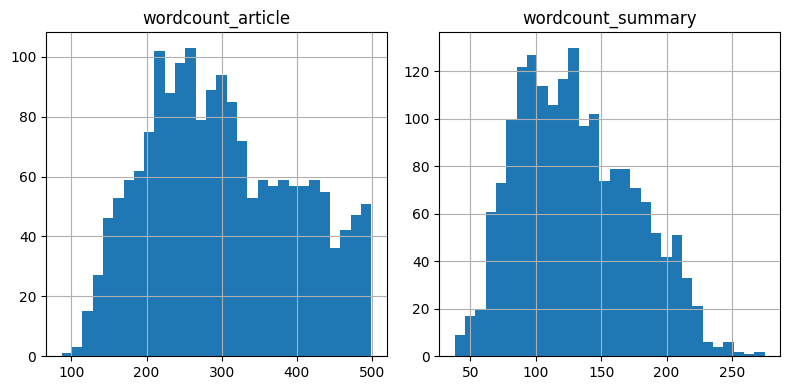

In [69]:
#Histogram to see whether removing outliers has smoothened the dataset
numerical_columns = filtered_df.select_dtypes(include=['int64'])

numerical_columns.hist(bins=30, figsize=(8, 4))
plt.tight_layout()

plt.show()

In [70]:
filtered_df = filtered_df.drop(['wordcount_article', 'wordcount_summary', 'path'], axis=1)

# Check the information of the updated DataFrame
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1783 entries, 0 to 1782
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   article   1783 non-null   object
 1   summary   1783 non-null   object
 2   category  1783 non-null   object
dtypes: object(3)
memory usage: 41.9+ KB


In [72]:
filtered_df.drop('category', axis=1, inplace=True)

In [73]:
filtered_df.head()

,article,summary
0,Johnson uncertain about Euro bid..Jade Johnson...,"""It's the stress,"" said Johnson.Jade Johnson i..."
1,Wood - Ireland can win Grand Slam..Former capt...,"""So many of the major England players have eit..."
2,Newcastle line up Babayaro..Newcastle manager ...,Babayaro has been in the Premiership since 199...
3,"Serena ends Sania Mirza's dream..Sania Mirza, ...","Sania Mirza, the first Indian woman to reach t..."
4,Wenger rules out new keeper..Arsenal boss Arse...,Arsenal boss Arsene Wenger says he has no plan...


In [74]:
#Currently in the dataframe, all the rows are neatly segregated by their category. So we shuffled them so as to not create any unknown bias.
from sklearn.utils import shuffle
df = shuffle(filtered_df)
df

,article,summary
973,Top Tories on Lib Dem 'hit list'..The Liberal ...,"A Conservative spokesperson said: ""The Liberal..."
749,Rock star sued by ex-girlfriend..Motley Crue g...,Motley Crue guitarist Mick Mars is being sued ...
168,Moya fights back for Indian title..Carlos Moya...,The ATP has announced that it would contribute...
34,Jones files Conte lawsuit..Marion Jones has fi...,"""Mr Conte chose to make unsubstantiated allega..."
484,Hundreds vie for best film Oscar..A total of 2...,A total of 267 films are eligible for the best...
...,...,...
452,Spike Lee backs student directors..Film-maker ...,"But when it comes time to do a movie, he has t..."
1505,US to rule on Yukos refuge call..Yukos has sai...,Yukos has said a US bankruptcy court will deci...
1138,Khodorkovsky ally denies charges..A close asso...,"Mr Khodorkovsky began his testimony last week,..."
1393,Metlife buys up Citigroup insurer..US banking ...,US banking giant Citigroup has sold its Travel...


I am calculating on 30% on the entire data as it's taking too long to train on the entire dataset.
As for how I settled on this 30%. I had tried it for 100%, 70%, and 30%. And the 30% model was working for me

In [20]:
# Calculate the number of rows to sample (30% of the original data)
sample_size = int(0.3 * len(df))

# Sample 30% of the data
sampled_df = df.sample(n=sample_size, random_state=42)
df = sampled_df

In [28]:
#Removing all stopwords from the dataframe

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
df['article'] = df['article'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df['summary'] = df['summary'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [30]:
#Converting all the letters into lowercase.
df['article'] = df['article'].str.lower()
df['summary'] = df['summary'].str.lower()

##Training the model

In [21]:
# Define the device for GPU usage (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tokenize and preprocess the text data
# Note that Maximum sequence length is 512
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
max_length = 512

# Move the tokenized inputs to the GPU
def tokenize_text(text):
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=512, truncation=True, padding='max_length', return_attention_mask=True)
    return inputs.to(device)

# Move the tokenized summaries to the GPU
def tokenize_summary(text):
    inputs = tokenizer.encode(text, return_tensors="pt", max_length=280, truncation=True, padding='max_length', return_attention_mask=True)
    return inputs.to(device)


df['TokenizedText'] = df['article'].apply(tokenize_text)
df['TokenizedSummary'] = df['summary'].apply(tokenize_summary)

# Split data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert tokenized data to PyTorch tensors
X_train = torch.stack([seq.squeeze() for seq in train_df['TokenizedText']])
Y_train = torch.stack([seq.squeeze() for seq in train_df['TokenizedSummary']])
X_test = torch.stack([seq.squeeze() for seq in test_df['TokenizedText']])
Y_test = torch.stack([seq.squeeze() for seq in test_df['TokenizedSummary']])

# Define a DataLoader for batching data
train_dataset = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataset = TensorDataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=4)

In [22]:
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

# Create a GradScaler for mixed-precision training
scaler = GradScaler()

# Define hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=50, num_training_steps=len(train_dataloader) * 10)
early_stopping_rounds = 2
best_rouge_score = -1
current_round = 0

accumulation_steps = 20

def train(model, dataloader, optimizer, scheduler):
    model.train()
    total_loss = 0.0
    optimizer.zero_grad()

    for step, batch in enumerate(tqdm(dataloader, desc="Training")):
        inputs = batch[0].to(device)
        attention_mask = (inputs != 0).float().to(device)  # Create attention mask
        targets = batch[1].to(device)

        with autocast():
            outputs = model(input_ids=inputs, attention_mask=attention_mask, decoder_input_ids=targets, labels=targets)
            loss = outputs.loss

        # Perform gradient accumulation
        loss = loss / accumulation_steps
        scaler.scale(loss).backward()

        if (step + 1) % accumulation_steps == 0:
            # Update gradients and optimizer once every accumulation_steps
            clip_grad_norm_(model.parameters(), max_norm=1.0)  # Optional gradient clipping
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def calculate_rouge1_precision(logits, targets):
    scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
    rouge1_precision = 0.0
    num_samples = len(logits)

    for i in range(num_samples):
        predicted_ids = logits[i].cpu().numpy()
        target_ids = targets[i].cpu().numpy()

        predicted_text = tokenizer.decode(predicted_ids, skip_special_tokens=True)
        target_text = tokenizer.decode(target_ids, skip_special_tokens=True)

        # Calculate ROUGE-1 precision
        scores = scorer.score(predicted_text, target_text)
        rouge1_precision += scores['rouge1'].precision

    return rouge1_precision / num_samples

# Training loop
for epoch in range(5):
    train_loss = train(model, train_dataloader, optimizer, scheduler)
    if epoch==5:
      print(f"Epoch 1/1, Train Loss: {train_loss:.4f}")

Training: 100%|██████████| 107/107 [51:45<00:00, 29.02s/it]

Epoch 1/1, Train Loss: 0.6633


##Evaluating on the test data

In [ ]:
def evaluate(model, dataloader):
    model.eval()

    test_articles = []
    actual_summaries = []
    predicted_summaries = []
    rouge1_precision_scores = []

    scorer = rouge_scorer.RougeScorer(['rouge1'])

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating Test"):
            inputs = batch[0].to(device)
            attention_mask = (inputs != 0).float().to(device)
            targets = batch[1].to(device)
            outputs = model.generate(input_ids=inputs, attention_mask=attention_mask, max_length=150, num_beams=17, length_penalty=2.0, early_stopping=False)

            for output, target, input_text in zip(outputs, targets, inputs):
                # Calculate ROUGE-1 precision for each sample
                output_text = tokenizer.decode(output, skip_special_tokens=True)
                target_text = tokenizer.decode(target, skip_special_tokens=True)
                rouge_scores = scorer.score(output_text, target_text)
                rouge1_precision_scores.append(rouge_scores['rouge1'].precision)

                # Append tokenized text, actual summaries, and predicted summaries
                test_articles.append(tokenizer.decode(input_text, skip_special_tokens=True))
                actual_summaries.append(target_text)
                predicted_summaries.append(output_text)

    return test_articles, actual_summaries, predicted_summaries, rouge1_precision_scores

# Evaluate the model
test_articles, actual_summaries, predicted_summaries, rouge1_precision_scores = evaluate(model, test_dataloader)

# Create a dictionary with the extracted data
data = {
    'Article': test_articles,
    'Actual Summary': actual_summaries,
    'Predicted Summary': predicted_summaries,
    'ROUGE-1 Precision': rouge1_precision_scores,
}

results_df = pd.DataFrame(data)

In [31]:
results_df.head()

,Article,Actual Summary,Predicted Summary,ROUGE-1 Precision
0,summarize: roche 'turns federer offer'..austra...,australian tennis coach tony roche turned appr...,summarize: roche 'turns federer offer'..austra...,0.777778
1,summarize: labour pig poster 'anti-semitic'..t...,"labour said poster ""not anti-jewish, anti-tory...",summarize: labour pig poster 'anti-semitic'..t...,0.350000
2,summarize: ronaldo considering new contract..m...,ronaldo refused commit long-term future club.i...,summarize: ronaldo considering new contract..m...,0.842857
3,summarize: bortolami predicts dour contest..it...,now italians travel edinburgh hoping claim fir...,summarize: bortolami predicts dour contest..it...,0.941176
4,summarize: henman & murray claim lta awards..t...,scotland's andrew murray named young player ye...,summarize: henman & murray claim lta awards..t...,0.561983


In [32]:
  results_df.mean()

ROUGE-1 Precision    0.570564
dtype: float64

The Rouge score we have gotten is considered a good score. So it proves our model is working and working well

In [27]:
#Pushing the model to huggingface for future use
model.push_to_hub("finetune")
tokenizer.push_to_hub("finetune")

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/amoghsinhaa/finetune/commit/ede46bfa3da78f1d700222284778b818fb7a3092', commit_message='Upload tokenizer', commit_description='', oid='ede46bfa3da78f1d700222284778b818fb7a3092', pr_url=None, pr_revision=None, pr_num=None)

In [35]:
#Directly using the model from hf to summarise.
from transformers import pipeline

pipe = pipeline("summarization", model="amoghsinhaa/finetune")
ARTICLE = """ New York (CNN)When Liana Barrientos was 23 years old, she got married in Westchester County, New York.
A year later, she got married again in Westchester County, but to a different man and without divorcing her first husband.
Only 18 days after that marriage, she got hitched yet again. Then, Barrientos declared "I do" five more times, sometimes only within two weeks of each other.
In 2010, she married once more, this time in the Bronx. In an application for a marriage license, she stated it was her "first and only" marriage.
Barrientos, now 39, is facing two criminal counts of "offering a false instrument for filing in the first degree," referring to her false statements on the
2010 marriage license application, according to court documents.
Prosecutors said the marriages were part of an immigration scam.
On Friday, she pleaded not guilty at State Supreme Court in the Bronx, according to her attorney, Christopher Wright, who declined to comment further.
After leaving court, Barrientos was arrested and charged with theft of service and criminal trespass for allegedly sneaking into the New York subway through an emergency exit, said Detective
Annette Markowski, a police spokeswoman. In total, Barrientos has been married 10 times, with nine of her marriages occurring between 1999 and 2002.
All occurred either in Westchester County, Long Island, New Jersey or the Bronx. She is believed to still be married to four men, and at one time, she was married to eight men at once, prosecutors say.
Prosecutors said the immigration scam involved some of her husbands, who filed for permanent residence status shortly after the marriages.
Any divorces happened only after such filings were approved. It was unclear whether any of the men will be prosecuted.
The case was referred to the Bronx District Attorney\'s Office by Immigration and Customs Enforcement and the Department of Homeland Security\'s
Investigation Division. Seven of the men are from so-called "red-flagged" countries, including Egypt, Turkey, Georgia, Pakistan and Mali.
Her eighth husband, Rashid Rajput, was deported in 2006 to his native Pakistan after an investigation by the Joint Terrorism Task Force.
If convicted, Barrientos faces up to four years in prison.  Her next court appearance is scheduled for May 18.
"""
print(pipe(ARTICLE))

[{'summary_text': ' New York (CNN)When Liana Barrientos was 23 years old, she got married in Westchester County, New York. She declared "I do" five times, sometimes only within two weeks of each other, according to court documents.She then filed for a marriage license in the Bronx, but without divorcing her first husband. She filed for permanent residence status in 2009.Only 18 days after that marriage, she became pregnant again. She got hitched yet again. Then, Barrientios declared "you do" four more times, and again, she filed for residency status in 2010.In 2010,'}]
